# Hadoop weird results

Hadoop is giving us weird, unlogical results. 

In [4]:
import pandas as pd

from helpers.load_data import (
    clean_column_names,
    get_data_with_cpu,
    get_experiments_paths,
    trim_experiment,
)
from helpers.regression import (
    boxplot_two,
    draw_regression_graph,
    fit_regression,
    get_coeff,
)

experiments_path = '../../data'

In [8]:
# basic_loads = ['linpack', 'redis_ycsb_d', 'sysbench']
basic_loads = ['linpack', 'redis_ycsb_d', 'hadoop_pagerank', 'sysbench']
redis_loads = [
    ('hadoop_pagerank', 'app_latency'),
    ('hadoop_kmeans', 'app_latency'),
]
df_coeffs = pd.DataFrame(columns=['impact_on'] + basic_loads)

for load_name, target in redis_loads:
    row = {'impact_on': load_name}
    
    for basic_load in basic_loads:
        experiment_name = f'{load_name}_1_{basic_load}_9'
        path = list(get_experiments_paths(experiment_name, experiments_path))[0]
        print(path)
        coeff = get_coeff(path, instances_n=7, trim_len=6, target=target)
        row[basic_load] = coeff
    
    df_coeffs = df_coeffs.append(row, ignore_index=True)
        
df_coeffs

../../data/hadoop_pagerank_1_linpack_9_m10


/home/godul/.local/lib/python3.7/site-packages/numpy/core/_methods.py:249: RuntimeWarning: invalid value encountered in subtract
  out


../../data/hadoop_pagerank_1_redis_ycsb_d_9_m10


/home/godul/.local/lib/python3.7/site-packages/numpy/core/_methods.py:249: RuntimeWarning: invalid value encountered in subtract
  out


../../data/hadoop_pagerank_1_hadoop_pagerank_9_m10


/home/godul/.local/lib/python3.7/site-packages/numpy/core/_methods.py:249: RuntimeWarning: invalid value encountered in subtract
  out


../../data/hadoop_pagerank_1_sysbench_9_m10


/home/godul/.local/lib/python3.7/site-packages/numpy/core/_methods.py:249: RuntimeWarning: invalid value encountered in subtract
  out


../../data/hadoop_kmeans_1_linpack_9_m10
../../data/hadoop_kmeans_1_redis_ycsb_d_9_m10
../../data/hadoop_kmeans_1_hadoop_pagerank_9_m10
../../data/hadoop_kmeans_1_sysbench_9_m10


,impact_on,linpack,redis_ycsb_d,hadoop_pagerank,sysbench
0,hadoop_pagerank,1629.069786,-292.900468,2087.214450,990.595323
1,hadoop_kmeans,258.057228,-1365.937688,2190.567163,527.993134


#### Normalized:

In [9]:
for i in range(len(df_coeffs)):
    df_coeffs.iloc[i, 1:] /= df_coeffs.at[i, 'linpack']

df_coeffs

,impact_on,linpack,redis_ycsb_d,hadoop_pagerank,sysbench
0,hadoop_pagerank,1.0,-0.179796,1.281231,0.608074
1,hadoop_kmeans,1.0,-5.293158,8.488688,2.046031


Negative coefficient for `redis_ycsb_d` - YIKES! 
It's difficult to explain it - it means that our initial load performs better with additional loads.

Let's see the graphs.

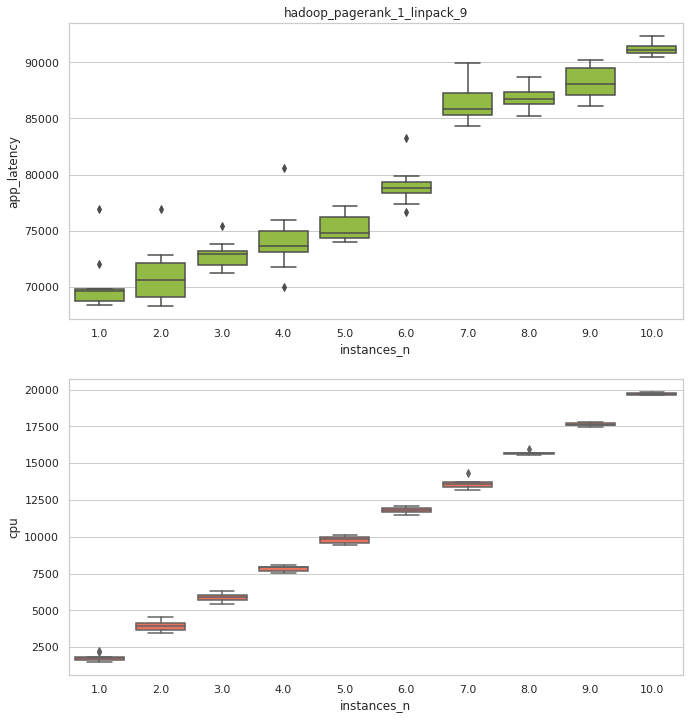

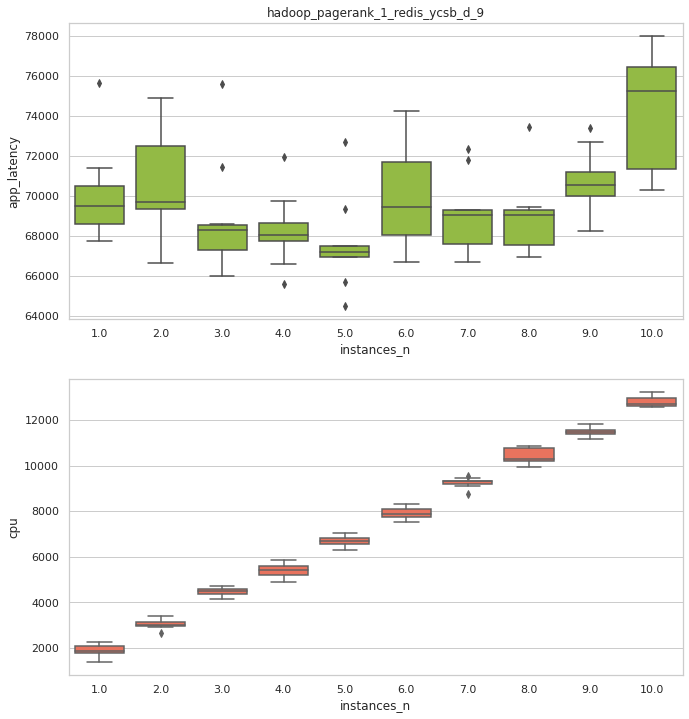

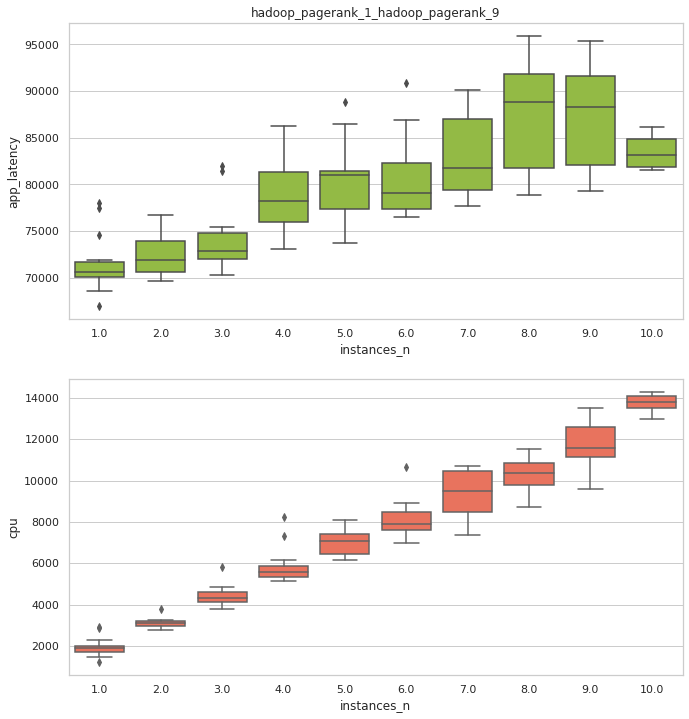

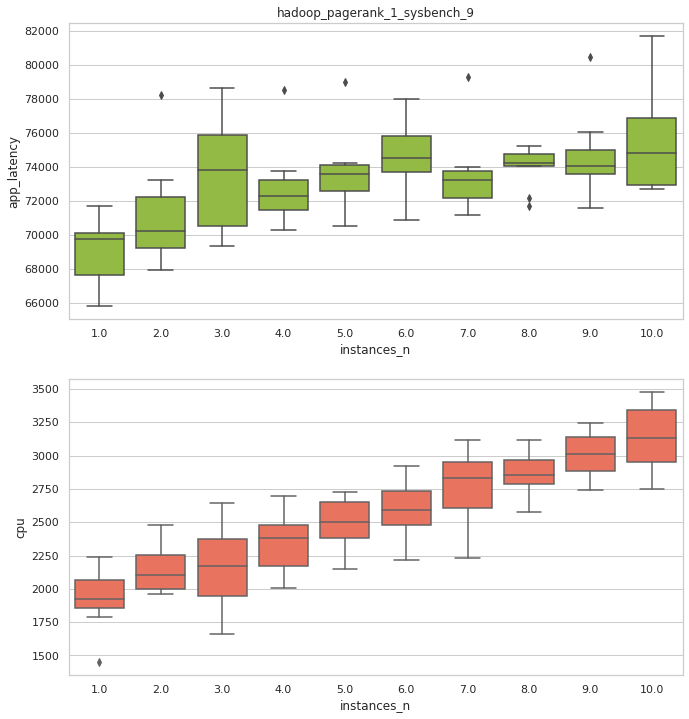

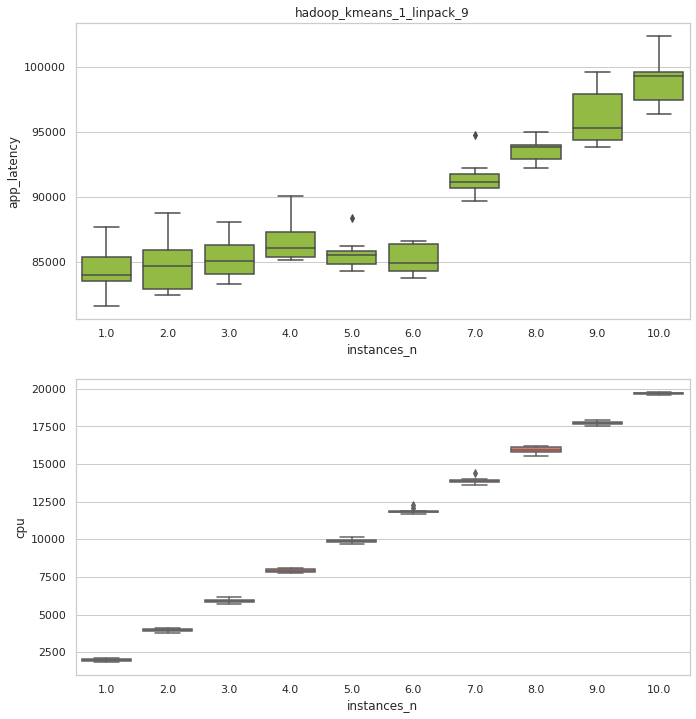

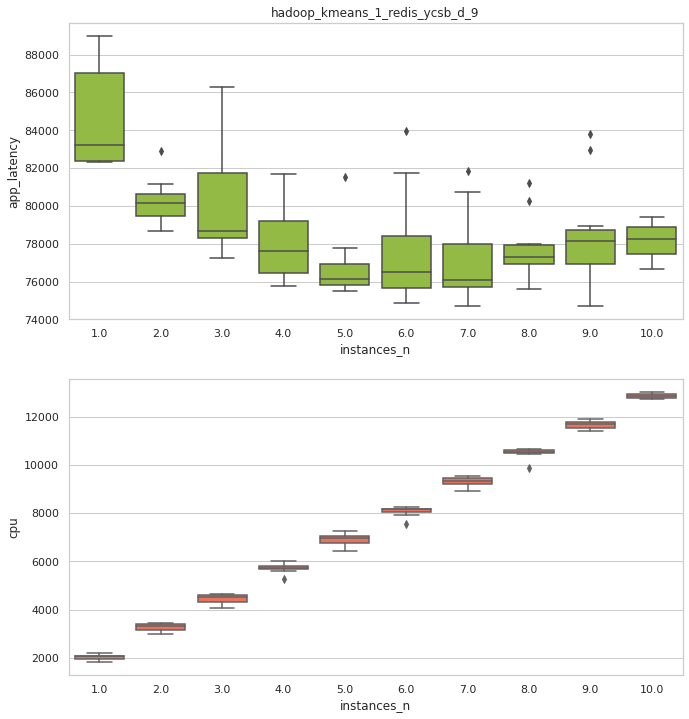

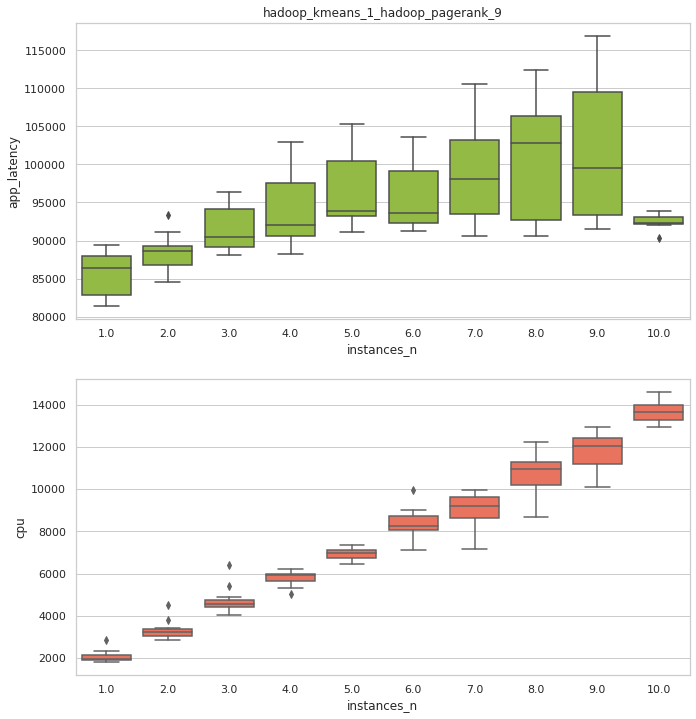

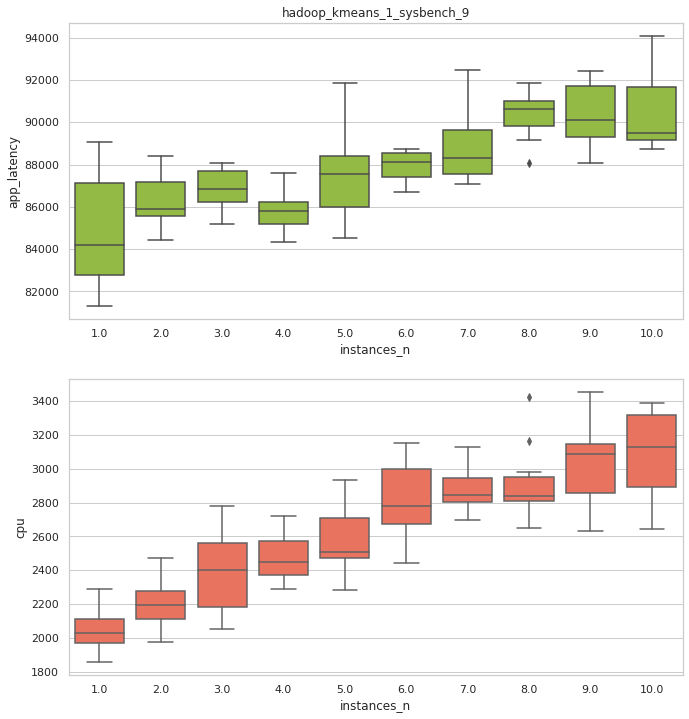

In [11]:
for load_name, target in redis_loads:
    row = {'impact_on': load_name}
    
    for basic_load in basic_loads:
        experiment_name = f'{load_name}_1_{basic_load}_9'
        path = list(get_experiments_paths(experiment_name, experiments_path))[0]
        df = get_data_with_cpu(path, instances_n=10, cpu_window=30)
        df = trim_experiment(df, 10)

        df_plot = pd.DataFrame()
        df_grp = df.groupby('instances_n').mean()
        df_plot['linpack'] = df_grp['app_latency']

        boxplot_two(var_1='app_latency', var_2='cpu', df=df, figsize=(11, 12), title=experiment_name)

We have a suspicion, that CPU limit on hadoop is too low and it affects the experiment. Let's increase it to 4 * mean (from 2 * mean) and see what happens.

In [13]:
# basic_loads = ['linpack', 'redis_ycsb_d', 'sysbench']
basic_loads = ['linpack', 'redis_ycsb_d', 'hadoop_pagerank', 'sysbench']
df_coeffs = pd.DataFrame(columns=['impact_on'] + basic_loads)
load_name = 'hadoop_pagerank'

row = {'impact_on': load_name}

for basic_load in basic_loads:
    experiment_name = f'{load_name}_1_{basic_load}_9'
    path = list(get_experiments_paths(experiment_name, experiments_path))[2]
    print(path)
    coeff = get_coeff(path, instances_n=7, trim_len=6, target='app_latency')
    row[basic_load] = coeff

df_coeffs = df_coeffs.append(row, ignore_index=True)
        
df_coeffs

../../data/hadoop_pagerank_1_linpack_9_m13


/home/godul/.local/lib/python3.7/site-packages/numpy/core/_methods.py:249: RuntimeWarning: invalid value encountered in subtract
  out


../../data/hadoop_pagerank_1_redis_ycsb_d_9_m13


/home/godul/.local/lib/python3.7/site-packages/numpy/core/_methods.py:249: RuntimeWarning: invalid value encountered in subtract
  out


../../data/hadoop_pagerank_1_hadoop_pagerank_9_m13


/home/godul/.local/lib/python3.7/site-packages/numpy/core/_methods.py:249: RuntimeWarning: invalid value encountered in subtract
  out


../../data/hadoop_pagerank_1_sysbench_9_m13


/home/godul/.local/lib/python3.7/site-packages/numpy/core/_methods.py:249: RuntimeWarning: invalid value encountered in subtract
  out


,impact_on,linpack,redis_ycsb_d,hadoop_pagerank,sysbench
0,hadoop_pagerank,1291.774399,144.788059,1262.03413,614.929524


In [14]:
for i in range(len(df_coeffs)):
    df_coeffs.iloc[i, 1:] /= df_coeffs.at[i, 'linpack']

df_coeffs

,impact_on,linpack,redis_ycsb_d,hadoop_pagerank,sysbench
0,hadoop_pagerank,1.0,0.112085,0.976977,0.476035


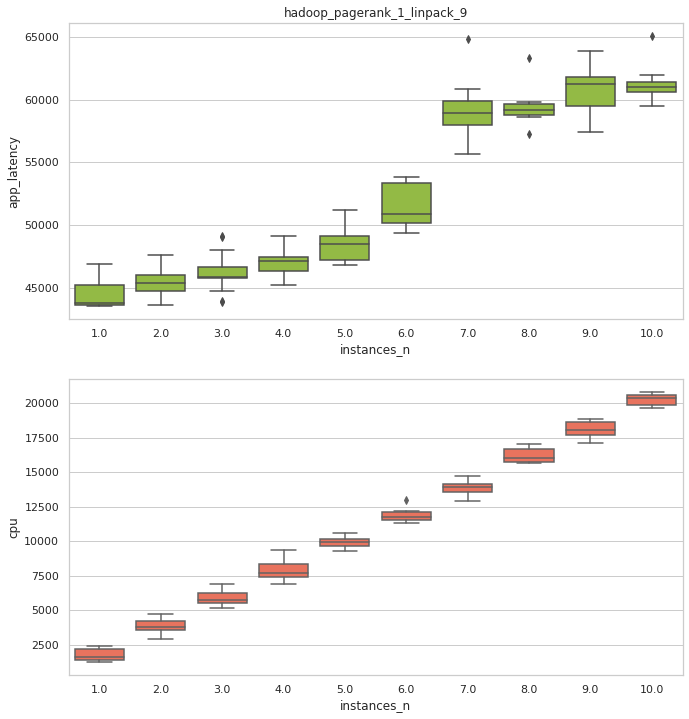

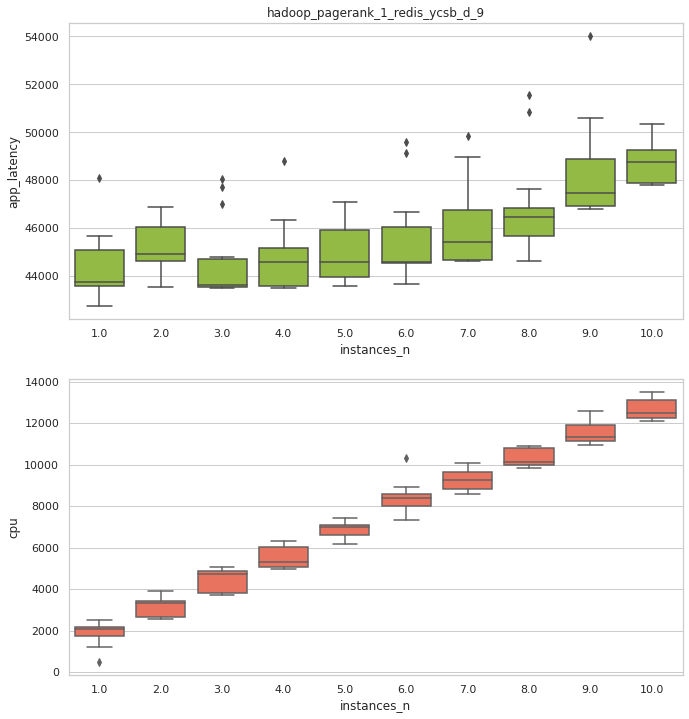

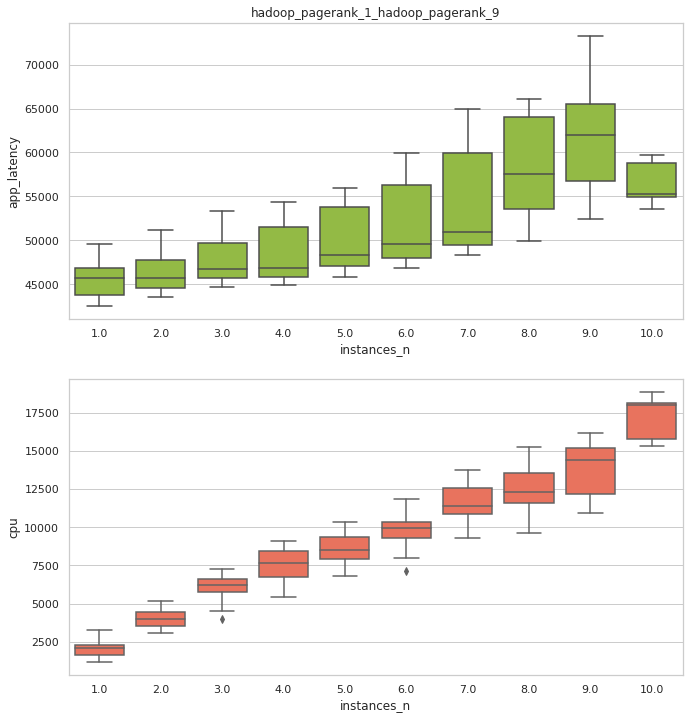

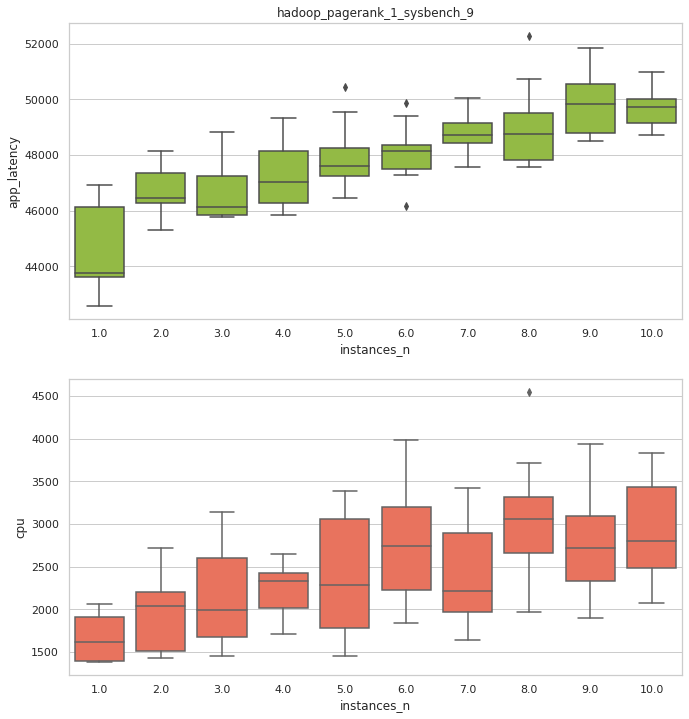

In [16]:
load_name = 'hadoop_pagerank'
row = {'impact_on': load_name}

for basic_load in basic_loads:
    experiment_name = f'{load_name}_1_{basic_load}_9'
    path = list(get_experiments_paths(experiment_name, experiments_path))[2]
    df = get_data_with_cpu(path, instances_n=10, cpu_window=30)
    df = trim_experiment(df, 10)

    df_plot = pd.DataFrame()
    df_grp = df.groupby('instances_n').mean()
    df_plot['linpack'] = df_grp['app_latency']

    boxplot_two(var_1='app_latency', var_2='cpu', df=df, figsize=(11, 12), title=experiment_name)